# Topic model of ACL privacy policy docs

In [89]:
# general imports
import warnings
import nltk
import pandas as pd
import numpy as np
import scipy as sp
from time import time, sleep
import json
import requests
import random
import os
import matplotlib.pyplot as plt
import re
from sklearn.externals import joblib
# Clean and lemmatize text
from nltk.corpus import stopwords
from gensim.utils import smart_open, simple_preprocess
from gensim.test.utils import datapath
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

import html5lib
import re
from bs4 import BeautifulSoup
import requests
from pprint import pprint
from pickle import dump,load
# Gensim
from gensim import similarities
import gensim
from gensim.corpora import Dictionary
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.summarization.summarizer import summarize
from pprint import pprint

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning)

random.seed(0)
# %matplotlib inline

In [9]:
def compute_coherence_lda(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
def format_topics_sentences(ldamodel, #optimal_model
                            corpus,#corpus
                            texts): #split_data_words
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series(
                        [int(topic_num),
                         round(prop_topic, 4), topic_keywords]),
                    ignore_index=True)
            else:
                break
    sent_topics_df.columns = [
        'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'
    ]

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)




# For new documents, extract the keywords
def get_topics_4_new_docs(model, topics, prob = .3):
    topics.sort(key=lambda x: x[1], reverse = True) #This is in-place
    topic_keywords = [model.show_topics()[topic[0]] for topic in vector if topic[1] > prob]
    return topic_keywords


# Display topics as a dataframe
def display_topics(feature_names, no_top_words, topic_words):
    word_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        #         print(topic_idx)
        #         print ([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        word_dict['Topic ' + str(topic_idx)] = [
            feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]
        ]
    return pd.DataFrame(
        word_dict
    )  #, columns=['Topic ' + str(k) for k in range(len(model.components_))])


# For user input text, returns which topic best fits the input
def fit_topic_to_text(text, count_vec, model):
    tf = count_vec.fit_transform(text)
    return (model.transform(tf))

In [49]:
# Load data
df = load(
    open("/Users/dbm/Documents/Insight S19/data/privacy_policy_acl_text.pkl",
         "rb"))
data_words = load(
    open(
        "/Users/dbm/Documents/Insight S19/data/acl_privacy_policy_words.pkl",
        "rb"))

In [50]:
df = df.reset_index(drop = True)
df.head(2)

,index,file,section,text,type
0,1,/Users/dbm/Downloads/corpus/www_google_co_nz.xml,Information we collect,We collect information to provide better servi...,pp
1,2,/Users/dbm/Downloads/corpus/www_google_co_nz.xml,How we use information we collect,We use the information we collect from all of ...,pp


In [74]:
print(df.shape, len(data_words))

(9585, 5) 9585


In [75]:
%%time
# Create corpora for topic modeling
split_data_words = [sentence.split() for sentence in data_words]

# Split data into train and test sets
# Use 150 
# unique_files = df['file'].unique()
# test_files = unique_files[:150].tolist()
# train_files = unique_files[151:].tolist()

# test_df = df[df['file'].isin(test_files)]
# train_df = df[df['file'].isin(train_files)]
test_df = df.iloc[:1500,:]
train_df = df.iloc[1500:,:]
print(f'Train (rows,cols): {train_df.shape}\nTest (rows, cols): {test_df.shape}')


Train (rows,cols): (8085, 5)
Test (rows, cols): (1500, 5)
CPU times: user 843 ms, sys: 31.3 ms, total: 875 ms
Wall time: 873 ms


In [78]:
len(split_data_words)

9585

In [79]:
test_words = split_data_words[:1500]
train_words = split_data_words[1500:]

print(len(test_words), len(train_words))

1500 8085


In [80]:
%%time
# Create dictionary train
id2word = corpora.Dictionary(train_words)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in train_words]

# Save corpora and dictionary
dump(corpus, open('acl_policy_corpus_train.pkl', 'wb'))
id2word.save('acl_policy_dictionary_train.gensim')

CPU times: user 1.26 s, sys: 36.4 ms, total: 1.29 s
Wall time: 1.3 s


In [81]:
%%time
# Create dictionary train
id2word_test = corpora.Dictionary(test_words)

# Term Document Frequency
corpus_test = [id2word.doc2bow(text) for text in test_words]

# Save corpora and dictionary
dump(corpus_test, open('acl_policy_corpus_test.pkl', 'wb'))
id2word_test.save('acl_policy_dictionary_test.gensim')

CPU times: user 235 ms, sys: 6.19 ms, total: 241 ms
Wall time: 239 ms


In [13]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [82]:
%%time
# Determine optimum number of topics
# Can take a long time to run
model_list, coherence_values = compute_coherence_lda(
    dictionary=id2word, corpus=corpus, texts=train_words, start=3, limit=30, step=1)

CPU times: user 5min 57s, sys: 7.86 s, total: 6min 5s
Wall time: 6min 18s


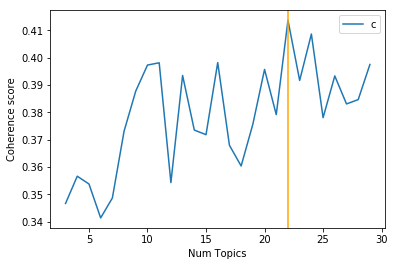

In [83]:
# Show graph
limit = 30
start = 3
step = 1
#  Find the index of the max value
max_idx = coherence_values.index(max(coherence_values))
# Sanity check
# coherence_values[19]
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.axvline(x=x[max_idx], color = 'orange')
plt.show()

In [84]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.3467
Num Topics = 4  has Coherence Value of 0.3567
Num Topics = 5  has Coherence Value of 0.3538
Num Topics = 6  has Coherence Value of 0.3414
Num Topics = 7  has Coherence Value of 0.3487
Num Topics = 8  has Coherence Value of 0.3732
Num Topics = 9  has Coherence Value of 0.3878
Num Topics = 10  has Coherence Value of 0.3973
Num Topics = 11  has Coherence Value of 0.3982
Num Topics = 12  has Coherence Value of 0.3543
Num Topics = 13  has Coherence Value of 0.3935
Num Topics = 14  has Coherence Value of 0.3736
Num Topics = 15  has Coherence Value of 0.3719
Num Topics = 16  has Coherence Value of 0.3982
Num Topics = 17  has Coherence Value of 0.368
Num Topics = 18  has Coherence Value of 0.3604
Num Topics = 19  has Coherence Value of 0.3757
Num Topics = 20  has Coherence Value of 0.3957
Num Topics = 21  has Coherence Value of 0.3792
Num Topics = 22  has Coherence Value of 0.4137
Num Topics = 23  has Coherence Value of 0.3917
Num Topics = 24  has 

In [85]:
# Select the model and print the topics
optimal_model = model_list[max_idx]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(3,
  '0.081*"cooky" + 0.034*"website" + 0.031*"information" + 0.028*"site" + '
  '0.026*"browser" + 0.022*"computer" + 0.021*"cookie" + 0.018*"persistent" + '
  '0.016*"session" + 0.016*"flash"'),
 (5,
  '0.042*"information" + 0.040*"country" + 0.038*"data" + 0.031*"state" + '
  '0.023*"personal" + 0.018*"transfer" + 0.017*"canada" + 0.015*"safe" + '
  '0.013*"protection" + 0.013*"harbor"'),
 (7,
  '0.054*"information" + 0.026*"site" + 0.021*"provide" + 0.020*"service" + '
  '0.017*"interest" + 0.014*"user" + 0.014*"product" + 0.011*"order" + '
  '0.011*"advertising" + 0.010*"party"'),
 (8,
  '0.078*"information" + 0.042*"personal" + 0.025*"secure" + 0.023*"security" '
  '+ 0.022*"protect" + 0.017*"site" + 0.015*"access" + 0.010*"data" + '
  '0.009*"internet" + 0.009*"provide"'),
 (1,
  '0.080*"information" + 0.035*"personal" + 0.026*"account" + 0.016*"access" + '
  '0.010*"request" + 0.010*"data" + 0.009*"contact" + 0.008*"applicable" + '
  '0.008*"purpose" + 0.008*"correct"'),
 (18

In [87]:
# Save model to disk.
temp_file = datapath("./optimal_LDA_model_acl_train")
optimal_model.save(temp_file)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, R = 20, sort_topics = True)
vis

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_tsne = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, R = 20, sort_topics = True, mds = 'tsne')
vis_tsne

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
16      -2.921224  253.736404       1        1  17.373259
14    -289.262848  156.847412       2        1  11.816196
7      137.201981  224.132263       3        1   8.419737
10    -243.450073   25.509327       4        1   8.165421
0      -26.251106  121.081177       5        1   6.621215
17     -51.364296 -114.048950       6        1   6.437121
1      -29.160358 -278.873230       7        1   5.288689
12      92.030594   93.902199       8        1   4.307220
4     -328.174408  -78.839287       9        1   4.157166
11     277.198303  -39.022781      10        1   3.920262
6      202.722626 -165.912857      11        1   3.153995
9      107.143539 -274.861542      12        1   3.064966
5       19.475763   -9.780786      13        1   2.626158
19    -149.972672  117.796768      14        1   2.469310
3       62.638866 -142.306061      15        1   2.002238
15    -180.413071  -87.958244      16        1   1.904253
18    -131.915375 -210.921722      17        1   1.786826
20    -147.006363  251.347519      18        1   1.585138
8      226.461243   99.555504      19        1   1.578963
2      -97.361732    6.531946      20        1   1.397679
13    -262.884247 -221.717499      21        1   1.245012
21     138.832031  -32.131214      22        1   0.679177, topic_info=      Category          Freq         Term         Total  loglift  logprob
53     Default  51816.000000  information  51816.000000  20.0000  20.0000
26     Default  10075.000000        cooky  10075.000000  19.0000  19.0000
77     Default  12093.000000        party  12093.000000  18.0000  18.0000
133    Default  12302.000000      website  12302.000000  17.0000  17.0000
500    Default  11289.000000        third  11289.000000  16.0000  16.0000
30     Default   8128.000000         data   8128.000000  15.0000  15.0000
142    Default   3456.000000       change   3456.000000  14.0000  14.0000
80     Default  14232.000000     personal  14232.000000  13.0000  13.0000
36     Default   7220.000000        email   7220.000000  12.0000  12.0000
719    Default   2370.000000        child   2370.000000  11.0000  11.0000
24     Default   4951.000000      contact   4951.000000  10.0000  10.0000
125    Default   8967.000000         user   8967.000000   9.0000   9.0000
104    Default  17223.000000         site  17223.000000   8.0000   8.0000
4      Default   8155.000000      address   8155.000000   7.0000   7.0000
6      Default   3937.000000  advertising   3937.000000   6.0000   6.0000
116    Default   5647.000000         time   5647.000000   5.0000   5.0000
499    Default   1570.000000       survey   1570.000000   4.0000   4.0000
91     Default   3968.000000      request   3968.000000   3.0000   3.0000
600    Default   3876.000000         mail   3876.000000   2.0000   2.0000
651    Default   1626.000000     question   1626.000000   1.0000   1.0000
4017    Topic1     39.818462  translation     40.833996   1.7251  -8.3803
5131    Topic1     37.778694   revocation     38.805851   1.7234  -8.4329
5174    Topic1     29.927803         eula     30.886354   1.7187  -8.6658
4330    Topic1     41.675129    officemax     43.064392   1.7174  -8.3347
4683    Topic1     36.033863    combining     37.274773   1.7164  -8.4801
7638    Topic1     23.028969     toolbars     23.987522   1.7095  -8.9278
4122    Topic1     25.136421    accessory     26.244314   1.7071  -8.8403
3697    Topic1     22.245878  associating     23.241430   1.7065  -8.9624
490     Topic1     29.659136        route     31.010035   1.7057  -8.6748
3887    Topic1     18.674829     detected     19.702877   1.6966  -9.1374
...        ...           ...          ...           ...      ...      ...
6619   Topic22      3.210448         pair      4.362061   4.6855  -7.6564
10303  Topic22      6.622879       battle      9.257003   4.6572  -6.9323
11333  Topic22     19.044888        foren     27.

In [35]:
# Find the dominant topic for each document
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=optimal_model, corpus=corpus, texts=split_data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(1)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.7746,"information, mobile, site, user, device, servi...","[collect, information, provide, better, servic..."


In [36]:
optimal_model.show_topics(formatted=True, num_words=10)

[(0,
  '0.033*"advertising" + 0.032*"information" + 0.032*"site" + 0.031*"party" + 0.029*"third" + 0.021*"cooky" + 0.019*"advertisement" + 0.017*"company" + 0.016*"network" + 0.014*"visit"'),
 (16,
  '0.092*"information" + 0.023*"site" + 0.018*"service" + 0.017*"address" + 0.016*"provide" + 0.016*"collect" + 0.015*"personal" + 0.014*"party" + 0.013*"third" + 0.012*"user"'),
 (11,
  '0.067*"information" + 0.026*"account" + 0.022*"address" + 0.020*"contact" + 0.016*"credit" + 0.016*"card" + 0.016*"email" + 0.016*"number" + 0.015*"name" + 0.014*"request"'),
 (5,
  '0.061*"data" + 0.036*"information" + 0.025*"state" + 0.024*"personal" + 0.018*"country" + 0.014*"protection" + 0.012*"service" + 0.011*"website" + 0.011*"consent" + 0.010*"site"'),
 (12,
  '0.087*"website" + 0.047*"site" + 0.040*"information" + 0.026*"party" + 0.026*"third" + 0.025*"link" + 0.012*"policy" + 0.011*"content" + 0.011*"practice" + 0.009*"responsible"'),
 (3,
  '0.031*"information" + 0.025*"forum" + 0.018*"public" +

In [51]:
# Merge topic info with main df
df_with_topic = pd.concat([df, df_dominant_topic], axis = 1)
df_with_topic.head(2)

,index,file,section,text,type,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,1,/Users/dbm/Downloads/corpus/www_google_co_nz.xml,Information we collect,We collect information to provide better servi...,pp,0,17.0,0.7746,"information, mobile, site, user, device, servi...","[collect, information, provide, better, servic..."
1,2,/Users/dbm/Downloads/corpus/www_google_co_nz.xml,How we use information we collect,We use the information we collect from all of ...,pp,1,17.0,0.5327,"information, mobile, site, user, device, servi...","[information, collect, service, provide, maint..."


## Summarize by topic

In [52]:
# Get the top n documents for each topic
df_topic_gr = df_with_topic.groupby('Dominant_Topic')
summary_stories = []

for group, _df in df_topic_gr:  
#     display(' '.join(_df['story']))
    summary = summarize(' '.join(_df['text']), ratio = .05, split = True)   
    summary_stories.append({'Dominant Topic':group, 'Summary':summary})


# df_with_topic = dfs.join(df.set_index('Document_No'), on='Document_No')
# df_with_topic.head(5)

KeyboardInterrupt: 

In [ ]:
optimal_model.bound()